## nn.Parameter
- nn.Module 내에 attribute가 될 때는 require_grad = True로 자동 지정된다.
- 하지만 torch내에 전부 만들어져 있으니까, 굳이 파라미터를 만들 필요는 없다.

In [2]:
import torch
from torch import nn
from torch import Tensor

## Backward
- 레이어에 있는 파라미터들의 미분을 수행
- forward 결과값(모델의 output)과 실제값간의 차이인 Loss에 대해 미분을 함

---
## 코드로 개념 확인하기
- 간단한 선형회귀 코드
- torch.nn.Linear() 를 통해서 자동으로 파라미터 지정이 된다.
- backward()가 실행될 때, optimizer가 작용을 한다. (SGD 실행)
- Module에서 backward와 optimizer를 오버라이딩하기 때문에 스크레치 코딩이 필요 없음

In [21]:
import numpy as np
# create dummy data for training
x_values = [i for i in range(11)]
x_train = np.array(x_values, dtype=np.float32)
x_train = x_train.reshape(-1, 1)

y_values = [2*i + 1 for i in x_values]
y_train = np.array(y_values, dtype=np.float32)
y_train = y_train.reshape(-1, 1)

In [22]:
from torch.autograd import Variable

class LinearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

### 변수 설정과 Optimizer 설정

In [23]:
inputDim = 1        # takes variable 'x' 
outputDim = 1       # takes variable 'y'
learningRate = 0.01 
epochs = 100

model = LinearRegression(inputDim, outputDim)
##### For GPU #######
if torch.cuda.is_available():
    model.cuda()

In [24]:
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### 학습

In [26]:
for epoch in range(epochs):
    # Converting inputs and labels to Variable
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(x_train).cuda())
        labels = Variable(torch.from_numpy(y_train).cuda())
    else:
        inputs = Variable(torch.from_numpy(x_train))
        labels = Variable(torch.from_numpy(y_train))

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    loss = criterion(outputs, labels)
    print(loss)
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

    print('epoch {}, loss {}'.format(epoch, loss.item()))

tensor(0.0105, grad_fn=<MseLossBackward>)
epoch 0, loss 0.010514849796891212
tensor(0.0104, grad_fn=<MseLossBackward>)
epoch 1, loss 0.010397433303296566
tensor(0.0103, grad_fn=<MseLossBackward>)
epoch 2, loss 0.010281295515596867
tensor(0.0102, grad_fn=<MseLossBackward>)
epoch 3, loss 0.010166511870920658
tensor(0.0101, grad_fn=<MseLossBackward>)
epoch 4, loss 0.010052960366010666
tensor(0.0099, grad_fn=<MseLossBackward>)
epoch 5, loss 0.009940705262124538
tensor(0.0098, grad_fn=<MseLossBackward>)
epoch 6, loss 0.009829671122133732
tensor(0.0097, grad_fn=<MseLossBackward>)
epoch 7, loss 0.009719964116811752
tensor(0.0096, grad_fn=<MseLossBackward>)
epoch 8, loss 0.009611411951482296
tensor(0.0095, grad_fn=<MseLossBackward>)
epoch 9, loss 0.009504104033112526
tensor(0.0094, grad_fn=<MseLossBackward>)
epoch 10, loss 0.00939792301505804
tensor(0.0093, grad_fn=<MseLossBackward>)
epoch 11, loss 0.009292983449995518
tensor(0.0092, grad_fn=<MseLossBackward>)
epoch 12, loss 0.0091892573982477

### 예측

In [27]:
with torch.no_grad(): # we don't need gradients in the testing phase
    if torch.cuda.is_available():
        predicted = model(Variable(torch.from_numpy(x_train).cuda())).cpu().data.numpy()
    else:
        predicted = model(Variable(torch.from_numpy(x_train))).data.numpy()
    print(predicted)


[[ 0.8905919]
 [ 2.9063475]
 [ 4.9221034]
 [ 6.937859 ]
 [ 8.953614 ]
 [10.96937  ]
 [12.985126 ]
 [15.000881 ]
 [17.016638 ]
 [19.032393 ]
 [21.04815  ]]


In [28]:
# 실제값
y_train

array([[ 1.],
       [ 3.],
       [ 5.],
       [ 7.],
       [ 9.],
       [11.],
       [13.],
       [15.],
       [17.],
       [19.],
       [21.]], dtype=float32)

### 파라미터 확인
파라미터를 찍어보면, 어떻게 업데이트가 됐는지 확인이 가능하다

In [29]:
for p in model.parameters():
    if p.requires_grad:
         print(p.name, p.data)

None tensor([[2.0158]])
None tensor([0.8906])


---
# Dataset API 활용

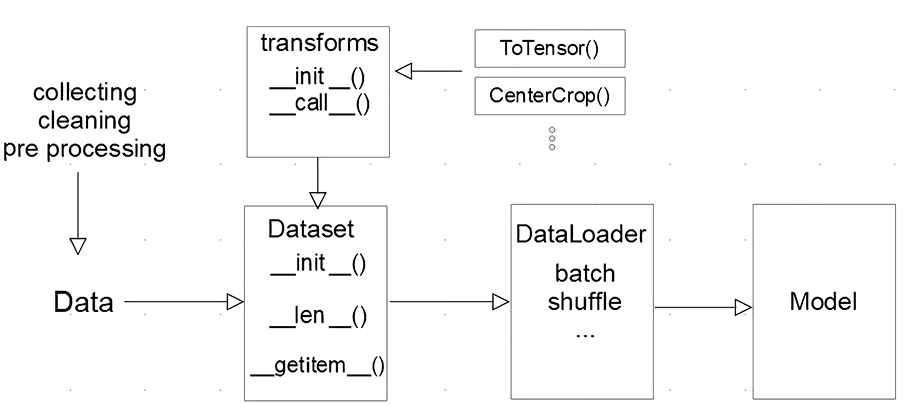

- Dataset의 getitem(): map-style, 하나의 데이터를 불러올 때 어떻게 반환할지를 선언
- transforms: 데이터 전처리, augmentation 할 때 사용함
- DataLoader: 데이터를 묶어서 모델에 feeding 할 때 사용함. (주로 배치를 만들 때)

## Dataset 클래스
- 데이터 입력 형태를 정의하는 클래스
- 데이터 입력하는 방식을 표준화함
- 데이터 형태에 따라 각 함수를 다르게 정의한다.


- 하지만 모든 것을 데이터 생성 시점에 처리할 필요는 없다!
- ex) 이미지의 tensor 변화는 학습에 필요한 시점에 변환함

In [32]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    # 초기 데이터 생성 방법을 지정
    def __init__(self, text, labels):
        self.labels = labels
        self.data = text
    
    # 데이터 전체 길이
    def __len__(self):
        return len(self.labels)
    
    # 인덱스 주었을 때 반환되는 데이터의 형태
    # 주로 dict 타입으로 줌
    def __getitem__(self, idx):
        label = self.labels[idx]
        text = self.data[idx]
        return {"Text": text, "Class": label}

## DataLoader 클래스
- 데이터의 Batch를 생성해주는 클래스이다.
- 학습 직전에(GPU에 feed하기 전) 데이터의 변환을 해주는 역할
- 주로, tensor로 변환 + batch 처리가 주요 업무임
- 다양한 파라미터들이 있음. (타임라인: 5강 15분)

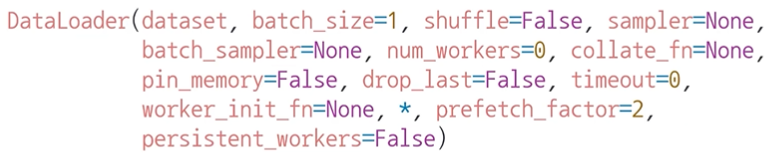

--- 
## CaseStudy
- VisionDataset의 NotMNIST 데이터를 다운받고
- Loader까지 구현해보기